In [3]:
import os  # For accessing environment variables and system functions
import json  # For handling JSON data
import getpass  # For securely getting user input for passwords
import operator  # For performing arithmetic operations

from langgraph.graph import END  # For defining the end of a graph workflow
from langchain_groq import ChatGroq  # For interacting with the ChatGroq model
from langchain.schema import Document  # For defining document schema
from langgraph.graph import StateGraph  # For creating and managing state graphs
from langchain_nomic.embeddings import NomicEmbeddings  # For generating document embeddings
from langchain_community.document_loaders import WebBaseLoader  # For loading documents from the web
from langchain_core.messages import HumanMessage, SystemMessage  # For defining message types
from langchain_community.vectorstores import SKLearnVectorStore  # For storing and retrieving document embeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter  # For splitting text into chunks
from langchain_community.tools.tavily_search import TavilySearchResults  # For performing web searches

from typing import List, Annotated  # For type annotations
from typing_extensions import TypedDict  # For defining typed dictionaries

from IPython.display import display, Markdown, clear_output, Image  # For displaying content in Jupyter notebooks

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [4]:
# This function clears the current output and displays the given text as Markdown
def display_md(text):
    clear_output()  # Clear the current output in the notebook
    display(Markdown(text))  # Display the given text as Markdown

# This function formats the given JSON data as a pretty-printed JSON string and displays it as Markdown
def display_json(json_data):
    display(Markdown(f"```json\n{json.dumps(json_data, indent=2)}\n```"))

In [5]:
# Set environment variable if not already set
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}")

In [6]:
# Set GROQ_API_KEY if not already set
_set_env("GROQ_API_KEY")

In [7]:
# Initialize ChatGroq with specified model and parameters
llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2
)

In [8]:
# Initialize ChatGroq with JSON response format
llm_json_mode = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    response_format={"type": "json_object"},
)

c:\Users\Makara\.conda\envs\ai-agents-env\Lib\site-packages\langchain_groq\chat_models.py:362: UserWarning: WARNING! response_format is not default parameter.
                    response_format was transferred to model_kwargs.
                    Please confirm that response_format is what you intended.
  warnings.warn(


In [9]:
# Define messages for the ChatGroq model
messages = [
    (
        "system",
        "You are a special kind of agent that when I give you a question, you will get the answer for that question by solving it step-by-step.",
    ),
    ("human", "How many `r` letters in the word `strawberry`"),
]

# Invoke the ChatGroq model with the defined messages
ai_msg = llm.invoke(messages)

In [10]:
# Display the response from the ChatGroq model
ai_msg

AIMessage(content="To find the number of `r` letters in the word `strawberry`, let's break it down step by step:\n\n1. Write down the word: `strawberry`\n2. Separate the word into individual letters: `s-t-r-a-w-b-e-r-r-y`\n3. Identify the `r` letters: `r` appears in the 3rd, 8th, and 9th positions.\n4. Count the number of `r` letters: There are 3 `r` letters in the word `strawberry`.\n\nTherefore, the answer is: **3**", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 125, 'prompt_tokens': 79, 'total_tokens': 204, 'completion_time': 0.454545455, 'prompt_time': 0.011897457, 'queue_time': 0.00021339199999999975, 'total_time': 0.466442912}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_fcc3b74982', 'finish_reason': 'stop', 'logprobs': None}, id='run-d8b2080f-2889-47b5-bbe6-38b7d2680520-0', usage_metadata={'input_tokens': 79, 'output_tokens': 125, 'total_tokens': 204})

In [11]:
# Display the response
display(Markdown(ai_msg.content))

To find the number of `r` letters in the word `strawberry`, let's break it down step by step:

1. Write down the word: `strawberry`
2. Separate the word into individual letters: `s-t-r-a-w-b-e-r-r-y`
3. Identify the `r` letters: `r` appears in the 3rd, 8th, and 9th positions.
4. Count the number of `r` letters: There are 3 `r` letters in the word `strawberry`.

Therefore, the answer is: **3**

### Search


In [12]:
# Set TAVILY_API_KEY environment variable
_set_env("TAVILY_API_KEY")

# Enable parallelism for tokenizers
os.environ["TOKENIZERS_PARALLELISM"] = "true"

### Tracing


In [13]:
# Set LANGSMITH_API_KEY environment variable
_set_env("LANGSMITH_API_KEY")

# Enable LangChain tracing
os.environ["LANGCHAIN_TRACING_V2"] = "true"

# Set LangChain project name
os.environ["LANGCHAIN_PROJECT"] = "self-correcting-rag-system"

### Vectorestore


In [14]:
# List of URLs to load documents from
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

In [15]:
# Load documents from URLs
docs = [WebBaseLoader(url).load() for url in urls]

# Flatten the list of documents
doc_list = [item for sublist in docs for item in sublist]

In [16]:
docs

[[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final res

In [17]:
doc_list

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [18]:
# Split documents into chunks
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000,
    chunk_overlap=200
)
doc_splits = text_splitter.split_documents(doc_list)

In [19]:
doc_splits

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [20]:
# Add document chunks to vector database
# Note: SKLearnVectorStore is used to store and retrieve document embeddings for similarity search
vectorstore = SKLearnVectorStore.from_documents(
    documents=doc_splits,
    embedding=NomicEmbeddings(
        model="nomic-embed-text-v1",
        inference_mode="local"
    )
)

In [21]:
# Create a retriever to fetch top 3 similar documents
retriever = vectorstore.as_retriever(k=3)
retriever

VectorStoreRetriever(tags=['SKLearnVectorStore', 'NomicEmbeddings'], vectorstore=<langchain_community.vectorstores.sklearn.SKLearnVectorStore object at 0x00000174A9256D80>, search_kwargs={})

### Components


#### Router


In [22]:
# Prompt instructions for routing user questions
router_instructions = """
    You are an expert at routing a user question to a `vectorstore` or `web search`.
    
    The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
    
    Use the vectorstore for questions on these topics. For all else, and especially for current events, use web-search.
    
    Return JSON with single key, `datasource`, that is 'websearch' or 'vectorstore' depending on the question.
"""

In [23]:
# Test router with different types of questions

# Test with a question likely to require web search
test_web_search = llm_json_mode.invoke(
    [SystemMessage(content=router_instructions)]
    + [HumanMessage(content="Who is favored to win the NFC Championship game in the 2024 season?")]
)

# Test with another question likely to require web search
test_web_search_2 = llm_json_mode.invoke(
    [SystemMessage(content=router_instructions)]
    + [HumanMessage(content="What are the models released today for llama 3.2?")]
)

# Test with a question likely to be answered by the vectorstore
test_vector_store = llm_json_mode.invoke(
    [SystemMessage(content=router_instructions)]
    + [HumanMessage(content="What are the types of agent memory?")]
)

In [24]:
# Print the results of the test router invocations
print(json.loads(test_web_search.content))
print(json.loads(test_web_search_2.content))
print(json.loads(test_vector_store.content))

{'datasource': 'websearch'}
{'datasource': 'websearch'}
{'datasource': 'vectorstore'}


#### Retrieval Grader


In [25]:
# Instructions for the document grader
doc_grader_instructions = """
    You are a grader assessing relevence of a retrieved document to a user question.
    If the document contains keyword(s) or sementic meaning related to the question, grade it as relevant.
"""

# Grader prompt
doc_grader_prompt = """**Here is the retrieved document:** \n\n {document} \n\n **Here is the user question:** \n\n {question}.\n\n
This carefully and objectively assess the document contains at least some information that is relevant to the question.
Return JSON with single key, `binary_score`, that is 'yes' or 'no' score to indicate whether the document is contains at least some information that is relevant to the question."""

In [27]:
display_md(doc_grader_prompt)

**Here is the retrieved document:** 

 {document} 

 **Here is the user question:** 

 {question}.


This carefully and objectively assess the document contains at least some information that is relevant to the question.
Return JSON with single key, `binary_score`, that is 'yes' or 'no' score to indicate whether the document is contains at least some information that is relevant to the question.

In [28]:
# Test the document grader
question = "What is Chain of thought prompting?"
docs = retriever.invoke(question)
doc_text = docs[1].page_content

# Format the grader prompt with the retrieved document and the question
doc_grader_prompt_formatted = doc_grader_prompt.format(
    document=doc_text, question=question
)

In [29]:
# Display the formatted grader prompt as Markdown
display_md(doc_grader_prompt_formatted)

**Here is the retrieved document:** 

 Use an iterative Monte Carlo search method to improve the best candidates by proposing semantically similar variants via prompts like Generate a variation of the following instruction while keeping the semantic meaning.\n\nInput: ...\n\nOutput:...


To construct chain-of-thought prompts automatically, Shum et al. (2023) suggested augment-prune-select, a three-step process:

Augment: Generate multiple pseudo-chains of thought given question using few-shot or zero-shot CoT prompts;
Prune: Prune pseudo chains based on whether generated answers match ground truths.
Select: Apply a variance-reduced policy gradient strategy to learn the probability distribution over selected examples, while considering the probability distribution over examples as policy and the validation set accuracy as reward.

Zhang et al. (2023) instead adopted clustering techniques to sample questions and then generates chains. They observed that LLMs tend to make certain types of mistakes. One type of errors can be similar in the emebedding space and thus get grouped together. By only sampling one or a few from frequent-error clusters, we can prevent too many wrong demonstrations of one error type and collect a diverse set of examples.

Question clustering: Embed questions and run $k$-means for clustering.
Demonstration selection: Select a set of representative questions from each cluster; i.e. one demonstration from one cluster. Samples in each cluster are sorted by distance to the cluster centroid and those closer to the centroid are selected first.
Rationale generation: Use zero-shot CoT to generate reasoning chains for selected questions and construct few-shot prompt to run inference.

Augmented Language Models#
A survey on augmented language models by Mialon et al. (2023) has great coverage over multiple categories of language models augmented with reasoning skills and the ability of using external tools. Recommend it.
Retrieval#
Often we need to complete tasks that require latest knowledge after the model pretraining time cutoff or internal/private knowledge base. In that case, the model would not know the context if we don’t explicitly provide it in the prompt. Many methods for Open Domain Question Answering depend on first doing retrieval over a knowledge base and then incorporating the retrieved content as part of the prompt. The accuracy of such a process depends on the quality of both retrieval and generation steps.
Lazaridou et al. (2022) studied how to use Google Search for document retrieval to augment LLMs. Given a question $q$, clean text is extracted out of 20 URLs returned by Google, resulting in a set of documents. Because these documents are long, each document is split into paragraphs of 6 sentences, $\{p\}$. Paragraphs are ranked by TF-IDF based cosine similarity between evidence paragraphs and the query. Only the most relevant paragraph is used in the prompt to produce an answer $a$.
For closed-book QA, each demonstration is formatted as follows to construct few-shot prompts. Swapping the question with the evidence (longer distance between questions and answers) is found to consistently yield lower results across all datasets.
Evidence: ...
Question: ...
Answer: ...
The answer probability is computed in three ways:

RAG style, $p(a_i \mid q) = \sum_{i=1}^n p_\text{tf-idf} (p_i \mid q) \cdot p_\text{LM}(a_i \mid q, p_i)$, where $p_\text{tf-idf} (p_i \mid q)$ is the normalized cosine similarities between the TF-IDF passage and question representations.
Noisy channel inference, $p(a_i\mid q) = \frac{p_\text{LM}(q \mid a_i, p_i) \cdot p_\text{LM}(a_i \mid p_i)}{p_\text{LM}(q \mid p_i)}$
Product-of-Experts (PoE), combines all probabilities used above in addition to $p_\text{LM}(p_i \mid q)$. 

 **Here is the user question:** 

 What is Chain of thought prompting?.


This carefully and objectively assess the document contains at least some information that is relevant to the question.
Return JSON with single key, `binary_score`, that is 'yes' or 'no' score to indicate whether the document is contains at least some information that is relevant to the question.

In [30]:
# Get the grading result
result = llm_json_mode.invoke(
    [SystemMessage(content=doc_grader_instructions)]
    + [HumanMessage(content=doc_grader_prompt_formatted)]
)

# Parse and display the result
json.loads(result.content)

{'binary_score': 'yes'}

#### Generate


In [33]:
# Prompt for the retrieval-augmented generation (RAG) model
rag_prompt = """You are an assistant for question-answering tasks.

Here is the context to use to answer the question:
{context}
\nThink carefully about the context.

Now, review the user question:
{question}

Provide an answer to this question using only the above context.
Use three sentences maximum and keep the answer concise.

Answer:"""


In [34]:
display_md(rag_prompt)

You are an assistant for question-answering tasks.

Here is the context to use to answer the question:
{context}

Think carefully about the context.

Now, review the user question:
{question}

Provide an answer to this question using only the above context.
Use three sentences maximum and keep the answer concise.

Answer:

In [35]:
# Post-processing function to format documents
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [36]:
# Test the RAG model with a question
docs = retriever.invoke(question)
docs_txt = format_docs(docs)

# Format the RAG prompt with the retrieved documents and the question
rag_prompt_formatted = rag_prompt.format(
    context=docs_txt,
    question=question
)

# Generate the answer using the RAG model
generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])

In [42]:
print(docs_txt)

[21] Chen et al. “Program of Thoughts Prompting: Disentangling Computation from Reasoning for Numerical Reasoning Tasks.” arXiv preprint arXiv:2211.12588 (2022).
[22] Gao et al. “PAL: Program-aided language models.” arXiv preprint arXiv:2211.10435 (2022).
[23] Parisi et al. “TALM: Tool Augmented Language Models” arXiv preprint arXiv:2205.12255 (2022).
[24] Schick et al. “Toolformer: Language Models Can Teach Themselves to Use Tools.” arXiv preprint arXiv:2302.04761 (2023).
[25] Mialon et al. “Augmented Language Models: a Survey” arXiv preprint arXiv:2302.07842 (2023).
[26] Yao et al. “Tree of Thoughts: Deliberate Problem Solving with Large Language Models.” arXiv preprint arXiv:2305.10601 (2023).

Use an iterative Monte Carlo search method to improve the best candidates by proposing semantically similar variants via prompts like Generate a variation of the following instruction while keeping the semantic meaning.\n\nInput: ...\n\nOutput:...


To construct chain-of-thought prompts autom

In [45]:
display_md(rag_prompt_formatted)

You are an assistant for question-answering tasks.

Here is the context to use to answer the question:
[21] Chen et al. “Program of Thoughts Prompting: Disentangling Computation from Reasoning for Numerical Reasoning Tasks.” arXiv preprint arXiv:2211.12588 (2022).
[22] Gao et al. “PAL: Program-aided language models.” arXiv preprint arXiv:2211.10435 (2022).
[23] Parisi et al. “TALM: Tool Augmented Language Models” arXiv preprint arXiv:2205.12255 (2022).
[24] Schick et al. “Toolformer: Language Models Can Teach Themselves to Use Tools.” arXiv preprint arXiv:2302.04761 (2023).
[25] Mialon et al. “Augmented Language Models: a Survey” arXiv preprint arXiv:2302.07842 (2023).
[26] Yao et al. “Tree of Thoughts: Deliberate Problem Solving with Large Language Models.” arXiv preprint arXiv:2305.10601 (2023).

Use an iterative Monte Carlo search method to improve the best candidates by proposing semantically similar variants via prompts like Generate a variation of the following instruction while keeping the semantic meaning.\n\nInput: ...\n\nOutput:...


To construct chain-of-thought prompts automatically, Shum et al. (2023) suggested augment-prune-select, a three-step process:

Augment: Generate multiple pseudo-chains of thought given question using few-shot or zero-shot CoT prompts;
Prune: Prune pseudo chains based on whether generated answers match ground truths.
Select: Apply a variance-reduced policy gradient strategy to learn the probability distribution over selected examples, while considering the probability distribution over examples as policy and the validation set accuracy as reward.

Zhang et al. (2023) instead adopted clustering techniques to sample questions and then generates chains. They observed that LLMs tend to make certain types of mistakes. One type of errors can be similar in the emebedding space and thus get grouped together. By only sampling one or a few from frequent-error clusters, we can prevent too many wrong demonstrations of one error type and collect a diverse set of examples.

Question clustering: Embed questions and run $k$-means for clustering.
Demonstration selection: Select a set of representative questions from each cluster; i.e. one demonstration from one cluster. Samples in each cluster are sorted by distance to the cluster centroid and those closer to the centroid are selected first.
Rationale generation: Use zero-shot CoT to generate reasoning chains for selected questions and construct few-shot prompt to run inference.

Augmented Language Models#
A survey on augmented language models by Mialon et al. (2023) has great coverage over multiple categories of language models augmented with reasoning skills and the ability of using external tools. Recommend it.
Retrieval#
Often we need to complete tasks that require latest knowledge after the model pretraining time cutoff or internal/private knowledge base. In that case, the model would not know the context if we don’t explicitly provide it in the prompt. Many methods for Open Domain Question Answering depend on first doing retrieval over a knowledge base and then incorporating the retrieved content as part of the prompt. The accuracy of such a process depends on the quality of both retrieval and generation steps.
Lazaridou et al. (2022) studied how to use Google Search for document retrieval to augment LLMs. Given a question $q$, clean text is extracted out of 20 URLs returned by Google, resulting in a set of documents. Because these documents are long, each document is split into paragraphs of 6 sentences, $\{p\}$. Paragraphs are ranked by TF-IDF based cosine similarity between evidence paragraphs and the query. Only the most relevant paragraph is used in the prompt to produce an answer $a$.
For closed-book QA, each demonstration is formatted as follows to construct few-shot prompts. Swapping the question with the evidence (longer distance between questions and answers) is found to consistently yield lower results across all datasets.
Evidence: ...
Question: ...
Answer: ...
The answer probability is computed in three ways:

RAG style, $p(a_i \mid q) = \sum_{i=1}^n p_\text{tf-idf} (p_i \mid q) \cdot p_\text{LM}(a_i \mid q, p_i)$, where $p_\text{tf-idf} (p_i \mid q)$ is the normalized cosine similarities between the TF-IDF passage and question representations.
Noisy channel inference, $p(a_i\mid q) = \frac{p_\text{LM}(q \mid a_i, p_i) \cdot p_\text{LM}(a_i \mid p_i)}{p_\text{LM}(q \mid p_i)}$
Product-of-Experts (PoE), combines all probabilities used above in addition to $p_\text{LM}(p_i \mid q)$.

Complexity-based consistency is to explicitly prefer complex chains among all the generations by taking majority vote among only top $k$ complex chains. (Fu et al. 2023)


Later, Shum et al. (2023) found that in their experiments CoT prompts with only complex examples can improve the accuracy of complex questions, but perform poorly in simple questions; evidence shown on GSM8k.


Changing Q: to Question: is found to be helpful. (Fu et al. 2023)


Ye & Durrett (2022) found that the benefit of including explanations in the prompt is small to moderate for NLP tasks that involve reasoning over text (i.e. QA and NLI) and the effects vary by models. They observed that explanations are more likely to be nonfactual than be inconsistent (i.e. whether explanation entails prediction). Nonfactual explanations most likely lead to incorrect predictions.


Self-Ask (Press et al. 2022) is a method to repeatedly prompt the model to ask following-up questions to construct the thought process iteratively. Follow-up questions can be answered by search engine results. Similarly, IRCoT (Interleaving Retrieval CoT; Trivedi et al. 2022) and ReAct (Reason + Act; Yao et al. 2023) combines iterative CoT prompting with queries to Wikipedia APIs to search for relevant entities and content and then add it back into the context.



Fig. 1. How Self-Ask works with external search queries.(Image source: Press et al. 2022).

Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, essentially creating a tree structure. The search process can be BFS or DFS while each state is evaluated by a classifier (via a prompt) or majority vote.


Fig. 2. How Self-Ask works with external search queries.(Image source: Yao et al. 2022).
Automatic Prompt Design#
Prompt is a sequence of prefix tokens that increase the probability of getting  desired output given input. Therefore we can treat them as trainable parameters and optimize them directly on the embedding space via gradient descent, such as AutoPrompt (Shin et al., 2020, Prefix-Tuning (Li & Liang (2021)), P-tuning (Liu et al. 2021) and Prompt-Tuning (Lester et al. 2021). This section in my “Controllable Neural Text Generation” post has a good coverage of them. The trend from AutoPrompt to Prompt-Tuning is that the setup gets gradually simplified.
APE (Automatic Prompt Engineer; Zhou et al. 2022) is a method to search over a pool of model-generated instruction candidates and then filters the candidate set according to a chosen score function to ultimately choose the best candidate with highest score.


Prompt LLM to generate instruction candidates based on a small set of demonstrations in the form of input-output pairs. E.g. {{Given desired input-output pairs}}\n\nThe instruction is.


Given a dataset of $\mathcal{D}_\text{train} = \{(x, y)\}$, we would like to find an instruction $\rho$ such that $\rho^* = \arg\max_\rho \mathbb{E}_{(x, y) \in \mathcal{D}_\text{train}} [f(\rho, x, y)]$, where $f(.)$ is a per-sample score function, such as execution accuracy $\mathbb{1}[\text{LM}(.\vert \rho, x)=y]$ or log probability: $p_\text{LM}(y \mid \rho, x)$.


Use an iterative Monte Carlo search method to improve the best candidates by proposing semantically similar variants via prompts like Generate a variation of the following instruction while keeping the semantic meaning.\n\nInput: ...\n\nOutput:...


To construct chain-of-thought prompts automatically, Shum et al. (2023) suggested augment-prune-select, a three-step process:

Augment: Generate multiple pseudo-chains of thought given question using few-shot or zero-shot CoT prompts;
Prune: Prune pseudo chains based on whether generated answers match ground truths.
Select: Apply a variance-reduced policy gradient strategy to learn the probability distribution over selected examples, while considering the probability distribution over examples as policy and the validation set accuracy as reward.

References#
[1] Zhao et al. “Calibrate Before Use: Improving Few-shot Performance of Language Models.” ICML 2021
[2] Liu et al. “What Makes Good In-Context Examples for GPT-3?” arXiv preprint arXiv:2101.06804 (2021).
[3] Lu et al. “Fantastically Ordered Prompts and Where to Find Them: Overcoming Few-Shot Prompt Order Sensitivity.” ACL 2022
[4] Ye et al. “In-Context Instruction Learning.” arXiv preprint arXiv:2302.14691 (2023).
[5] Su et al. “Selective annotation makes language models better few-shot learners.” arXiv preprint arXiv:2209.01975 (2022).
[6] Rubin et al. “Learning to retrieve prompts for in-context learning.” NAACL-HLT 2022
[7] Wei et al. “Chain of thought prompting elicits reasoning in large language models.” NeurIPS 2022
[8] Wang et al. “Self-Consistency Improves Chain of Thought Reasoning in Language Models.” ICLR 2023.
[9] Diao et al. “Active Prompting with Chain-of-Thought for Large Language Models.” arXiv preprint arXiv:2302.12246 (2023).
[10] Zelikman et al. “STaR: Bootstrapping Reasoning With Reasoning.” arXiv preprint arXiv:2203.14465 (2022).
[11] Ye & Durrett. “The unreliability of explanations in few-shot in-context learning.” arXiv preprint arXiv:2205.03401 (2022).
[12] Trivedi et al. “Interleaving retrieval with chain-of-thought reasoning for knowledge-intensive multi-step questions.” arXiv preprint arXiv:2212.10509 (2022).
[13] Press et al. “Measuring and narrowing the compositionality gap in language models.” arXiv preprint arXiv:2210.03350 (2022).
[14] Yao et al. “ReAct: Synergizing reasoning and acting in language models.” ICLR 2023.
[15] Fu et al. “Complexity-based prompting for multi-step reasoning.” arXiv preprint arXiv:2210.00720 (2022).
[16] Wang et al. “Rationale-augmented ensembles in language models.” arXiv preprint arXiv:2207.00747 (2022).
[17] Zhang et al. “Automatic chain of thought prompting in large language models.” arXiv preprint arXiv:2210.03493 (2022).
[18] Shum et al. “Automatic Prompt Augmentation and Selection with Chain-of-Thought from Labeled Data.” arXiv preprint arXiv:2302.12822 (2023).
[19] Zhou et al. “Large Language Models Are Human-Level Prompt Engineers.” ICLR 2023.
[20] Lazaridou et al. “Internet augmented language models through few-shot prompting for open-domain question answering.” arXiv preprint arXiv:2203.05115 (2022).
[21] Chen et al. “Program of Thoughts Prompting: Disentangling Computation from Reasoning for Numerical Reasoning Tasks.” arXiv preprint arXiv:2211.12588 (2022).
[22] Gao et al. “PAL: Program-aided language models.” arXiv preprint arXiv:2211.10435 (2022).
[23] Parisi et al. “TALM: Tool Augmented Language Models” arXiv preprint arXiv:2205.12255 (2022).
[24] Schick et al. “Toolformer: Language Models Can Teach Themselves to Use Tools.” arXiv preprint arXiv:2302.04761 (2023).

Think carefully about the context.

Now, review the user question:
What is Chain of thought prompting?

Provide an answer to this question using only the above context.
Use three sentences maximum and keep the answer concise.

Answer:

In [46]:
# Display the generated answer as Markdown
display_md(generation.content)

Chain of thought prompting is a technique that elicits reasoning in large language models by generating multiple pseudo-chains of thought given a question. This process involves augmenting, pruning, and selecting examples to learn the probability distribution over selected examples, as suggested by Shum et al. (2023). The goal of chain of thought prompting is to improve the accuracy of complex questions by providing a step-by-step thought process, as seen in methods like Tree of Thoughts and Self-Ask.

#### Hallucination Grader


In [47]:
# Hallucination grader instructions
hallucination_grader_instructions = """You are a teacher grading a quiz.
You will be given `FACTS` and `STUDENT ANSWER`.\n\n

Here is the grade criteria:\n
1. Ensure the `STUDENT ANSWER` is grounded in the `FACTS`
2. Ensure the `STUDENT ANSWER` does not contain "hallucinated" information outside the scope of the `FACTS`.\n\n

Score:
"""

# Display the hallucination grader instructions as Markdown
display_md(hallucination_grader_instructions)

You are a teacher grading a quiz.
You will be given `FACTS` and `STUDENT ANSWER`.



Here is the grade criteria:

1. Ensure the `STUDENT ANSWER` is grounded in the `FACTS`
2. Ensure the `STUDENT ANSWER` does not contain "hallucinated" information outside the scope of the `FACTS`.



Score:


In [48]:
# Grader prompt for hallucination detection
hallucination_grader_prompt = """FACTS: \n\n {documents} \n\n STUDENT ANSWER: \n\n {generation}. \n\n
Return JSON with two keys: `binary_score` which is 'yes' or 'no' to indicate whether the `STUDENT ANSWER` is grounded in the `FACTS`, and `explanation` which contains an explanation of the score."""

# Display the hallucination grader prompt as Markdown
display_md(hallucination_grader_prompt)

FACTS: 

 {documents} 

 STUDENT ANSWER: 

 {generation}. 


Return JSON with two keys: `binary_score` which is 'yes' or 'no' to indicate whether the `STUDENT ANSWER` is grounded in the `FACTS`, and `explanation` which contains an explanation of the score.

In [49]:
# Test the hallucination grader using the documents and generation from above
hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(
    documents=docs_txt,
    generation=generation.content
)

result = llm_json_mode.invoke(
    [SystemMessage(content=hallucination_grader_instructions)]
    + [HumanMessage(content=hallucination_grader_prompt_formatted)]
)

# Display the result as JSON
display_json(json.loads(result.content))

```json
{
  "binary_score": "yes",
  "explanation": "The student answer is grounded in the facts as it accurately describes chain of thought prompting and its goal, referencing the augment-prune-select process suggested by Shum et al. (2023) and mentioning specific methods like Tree of Thoughts and Self-Ask, which are all present in the provided facts."
}
```

#### Answer Grader


In [50]:
# Answer grader instructions
answer_grader_instructions = """You are a teacher grading a quiz.
You will be given `QUESTION` and a `STUDENT ANSWER`.\n\n

Here is the grade criteria to follow:
1. The `STUDENT ANSWER` helps to answer the `QUESTION`

Score:\n
A score of `yes` means that the student's answer meets all of the criteria. This is the `highest (best)` score.
The student can receive a score of yes if the answer contains extra information that is not explicitly asked for in the question.
A score of `no` means that the student's answer does not meet all of the criteria. This is the `lowest` possible score you can give.
Explain your reasoning in a step by step manner to ensure your reasoning and conclusion are correct.
Avoid simply stating the correct answer at the outset."""

# Grader prompt for answer grading
answer_grader_prompt = """QUESTION: \n\n {question} \n\nSTUDENT ANSWER:\n\n{generation} \n\n
Return JSON with two keys: `binary_score` which is 'yes' or 'no' to indicate whether the `STUDENT ANSWER` meets the criteria, and `explanation` which contains an explanation of the score."""

# Display the answer grader prompt as Markdown
display_md(answer_grader_prompt)

QUESTION: 

 {question} 

STUDENT ANSWER:

{generation} 


Return JSON with two keys: `binary_score` which is 'yes' or 'no' to indicate whether the `STUDENT ANSWER` meets the criteria, and `explanation` which contains an explanation of the score.

In [51]:
# Test the answer grader with a question and an answer
question = "What are the vision models released today as part of Llama 3.2?"
answer = "The Llama 3.2 models released today include two vision models: Llama 3.2 11B Vision Instruct and LLama 3.2 90B Vision Instruct, which are available on Azure AI Model CAtalog via managed compute. These models are part of Meta's first foray into multimodel AI and rival closed models like Anthropic's Claude 3 Haiku and OpenAI's GPT-4o mini in visual reasoning. They replace the order text-only Llama 3.1 models."

In [52]:
# Test using the question and generation from above
answer_grader_prompt_formatted = answer_grader_prompt.format(
    question=question,
    generation=answer
)

result = llm_json_mode.invoke(
    [SystemMessage(content=answer_grader_instructions)]
    + [HumanMessage(content=answer_grader_prompt_formatted)]
)

# Display the result as JSON
display_json(json.loads(result.content))

```json
{
  "binary_score": "yes",
  "explanation": "The student's answer meets the criteria because it directly addresses the question by listing the vision models released as part of Llama 3.2, specifically mentioning the Llama 3.2 11B Vision Instruct and LLama 3.2 90B Vision Instruct models. The answer provides additional context about the models' availability and their significance in the field of multimodel AI, which is not explicitly required by the question but does help to further inform the answer."
}
```

### Web Search Tool


#### Search


In [53]:
# Initialize the web search tool with top 3 search results
web_search_tool = TavilySearchResults(k=3)

## Graph


In [72]:
class GraphState(TypedDict):
    """
    Graph state is a dictionary that contains information we want to propagate to, and modify in,
    each node
    """
    
    question: str # user question
    generation: str # llm generation
    web_search: str # binary decision to run web search
    max_retries: int # max number of retries for answer generation
    answers: int # number of answers generated
    loop_step: Annotated[int, operator.add] # current loop step
    documents: List[str] # list of retrieved documents

### Nodes

#### retrieve()


In [61]:
def retrieve(state):
    """
    Retrieve documents from vectorstore
    
    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    
    print("---RETRIEVE---")
    question = state["question"]
    
    # Write retrieved documents to documents key in state
    documents = retriever.invoke(question)
    return {"documents": documents}

generate()


In [62]:
def generate(state):
    """
    Generate answer using RAG on retrieved documents
    
    Args:
        state (dict): The current graph state
    
    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    loop_step = state.get("loop_step", 0)
    
    # RAG generation
    docs_txt = format_docs(documents)
    rag_prompt_formatted = rag_prompt.format(
        context=docs_txt,
        question=question
    )
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    
    return {
        "generation": generation,
        loop_step: loop_step + 1
    }

grade_documents()


In [63]:
def grade_documents(state):
    """
    Determine whether the retrieved documents are relevant to the question
    If any document is not relevent, we will set a flag to run web search
    
    Args:
        state (dict): The current graph state
        
    Returns:
        state (dict): Filtered out irrelevant documents and updated web_serarch state
    """
    
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    
    # score each doc
    filtered_docs = []
    
    web_search = "No"
    
    for d in documents:
        doc_grader_prompt_formatted = doc_grader_prompt.format(
            document = d.page_content,
            question=question
        )
        
        result = llm_json_mode.invoke(
            [SystemMessage(content=doc_grader_instructions)]
            + [HumanMessage(content=doc_grader_prompt_formatted)]
        )
        
        grade = json.loads(result.content)["binary_score"]
        
        # document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # we do not include the document in filtered_docs
            # we set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    
    return {
        "documents": filtered_docs,
        "web_search": web_search
    }

web_search()


In [64]:
def web_search(state):
    """
    Web search based on the question
    
    Args:
        state (dict): The current graph state
        
    Returns:
        state (dict): Appended web results to documents
    """
    
    print("---WEB SEARCH---")
    question = state["question"]
    documents = state.get("documents", [])
    
    # web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    
    return {"documents": documents}

### Edges


route_question()


In [79]:
def route_question(state):
    """
    Route question to web search or RAG
    
    Args:
        state (dict): The current graph state
        
    Returns:
        str: Next node to call
    """
    
    print("---ROUTE QUESTION---")
    route_question = llm_json_mode.invoke(
        [SystemMessage(content=router_instructions)]
        + [HumanMessage(content=state["question"])]
    )
    
    source = json.loads(route_question.content)["datasource"]
    if source == "websearch":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    else:
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

In [66]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search
    
    Args:
        state (dict): The current graph state
    Returns:
        str: Binary decision for next node to call
    """
    
    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]
    
    if web_search == "Yes":
        # all documents have been filtered check_relevance
        # we will re-generate a new query
        print(
            "---DECISION: NOT ALL DOCUMENTS ARE RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
        )
        
        return "web_search"
    else:
        # we have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

grade_generation_v_documents_and_question()


In [67]:
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question
    
    Args:
        state (dict): The current graph state
        
    Returns:
        str: Decision for next node to call
    """
    
    print("---CHECK HALUCINATIONS")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
    max_retries = state.get("max_retries", 3) # default to 3 if not provided
    
    hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(
        documents = format_docs(documents),
        generation = generation.content
    )
    result = llm_json_mode.invoke(
        [SystemMessage(content=hallucination_grader_instructions)]
        + [HumanMessage(content=hallucination_grader_prompt_formatted)]
    )
    grade = json.loads(result.content)["binary_score"]
    
    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        
        # test using question and generation from above
        answer_grader_prompt_formatted = answer_grader_prompt.format(
            question=question,
            generation=generation.content
        )
        result = llm_json_mode.invoke(
            [SystemMessage(content=answer_grader_instructions)]
            + [HumanMessage(content=answer_grader_prompt_formatted)]
        )
        
        grade = json.loads(result.content)["binary_score"]
        
        if grade == "yes":
            print("---DECISION: GENERATION ANSWERS QUESTION---")
            return "useful"
        elif state["loop_step"] <= max_retries:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
        else:
            print("---DECISION: MAX RETRIES REACHED---")
            return "max retries"
    elif state["loop_step"] <= max_retries:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"
    else:
        print("---DECISION: MAX RETRIES REACHED---")
        return "max retries"

### Control Flow


In [82]:
# Initialize the workflow with the GraphState
workflow = StateGraph(GraphState)

In [83]:
# define the nodes
workflow.add_node("websearch", web_search) # web search
workflow.add_node("retrieve", retrieve) # retrieve
workflow.add_node("grade_documents", grade_documents) # grade documents
workflow.add_node("generate", generate) # generate

In [84]:
# build graph
workflow.set_conditional_entry_point(
    route_question, # route the question to web search or vectorstore
    {
        "websearch": "websearch", # if question needs web search
        "vectorstore": "retrieve", # if question can be answered from vectorstore
    },
)

# add edges between nodes
workflow.add_edge("websearch", "generate") # after web search, generate answer
workflow.add_edge("retrieve", "grade_documents") # after retrieval, grade docs

# conditional edge after grading docs
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch", # if docs not relevant, do web search
        "generate": "generate", # if docs relevant, generate answer
    },
)

# conditional edge after generating answer
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate", # regenerate if not supported
        "useful": END, # end if answer useful
        "not useful": "websearch", # web search if not useful
        "max retries": END, # end if max retries reached
    },
)

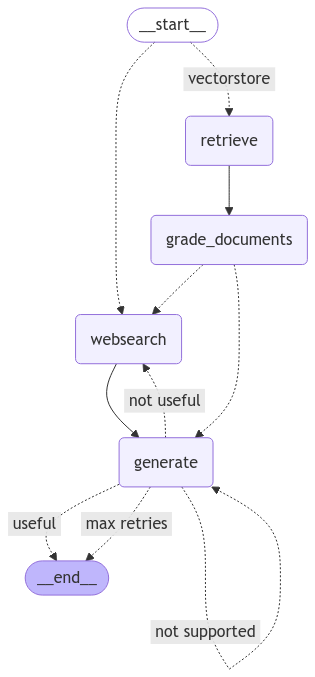

In [85]:
# Compile the workflow graph
graph = workflow.compile()

# Display the compiled graph as an image
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Define inputs for the workflow
inputs = {"question": "What are the types of agent memory?", "max_retries": 3}

# Stream events from the compiled graph
for event in graph.stream(inputs, stream_mode="values"):
    print(event)

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
{'question': 'What are the types of agent memory?', 'max_retries': 3, 'loop_step': 0}
---RETRIEVE---
{'question': 'What are the types of agent memory?', 'max_retries': 3, 'loop_step': 0, 'documents': [Document(metadata={'id': '1141f378-549c-4b2c-9b9f-886550bd1bea', 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks

In [87]:
# Test the workflow on a current events question
inputs = {
    "question": "What are the models released today for llama3.2?",
    "max_retries": 3,
}

# Stream events from the compiled graph
for event in graph.stream(inputs, stream_mode="values"):
    print(event)

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
{'question': 'What are the models released today for llama3.2?', 'max_retries': 3, 'loop_step': 0}
---WEB SEARCH---
{'question': 'What are the models released today for llama3.2?', 'max_retries': 3, 'loop_step': 0, 'documents': [Document(metadata={}, page_content="IBM is announcing the availability of multiple Llama 3.2 models on watsonx.ai, IBM’s enterprise studio for AI developers, following the launch of the Llama 3.2 collection of pretrained and instruction tuned multilingual large language models (LLMs) at MetaConnect earlier today. The instruction-tuned Llama 3.2 90B Vision and 11B Vision models are immediately available in watsonx.ai through SaaS. Support for Llama 3.2 is part of IBM’s commitment to furthering open source innovation in AI and providing our clients with access to best-in-class open models in watsonx, including both third party models and the IBM Granite model family. IBM watsonx helps enable clients to truly